# Plant-Seedlings-Classification

## - Jayabharathi Hari(https://www.jayabharathi-hari.com/)

• **DOMAIN**: Botanical Research

• **CONTEXT**: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at
various stages of growth. They already have have invested on curating sample images. They require an automation which can create a
classifier capable of determining a plant's species from a photo.

• **DATA DESCRIPTION**: The dataset comprises of images from 12 plant species.

**Source**: https://www.kaggle.com/c/plant-seedlings-classification/data.

• **PROJECT OBJECTIVE**: To create a classifier capable of determining a plant's species from a photo.

In [1]:
#Importing the packages
import tensorflow as tf
tf.__version__

import random
random.seed(0)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

from glob import glob

In [2]:
#Importing the packages

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#assisgning the zipped folder location to a variable
Base_path_Zip = '/content/gdrive/MyDrive/Education/GL_Data/plant-seedlings-classification.zip'

In [6]:
#Unzipping to new folder google drive.
from zipfile import ZipFile

try:
    with ZipFile(Base_path_Zip, 'r') as zip_ref:
        # Print the list of files in the ZIP file for debugging
        print("Files in ZIP:", zip_ref.namelist())

        zip_ref.extractall('/content/gdrive/MyDrive/Education/GL_Data/Plant_Seed_Train')
    print("Extraction successful.")
except FileNotFoundError:
    print(f"Error: The file '{Base_path_Zip}' was not found.")
except PermissionError:
    print(f"Error: Permission issue. Make sure you have the necessary permissions.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Files in ZIP: ['plant-seedlings-classification/', 'plant-seedlings-classification/.DS_Store', '__MACOSX/plant-seedlings-classification/._.DS_Store', 'plant-seedlings-classification/train/', 'plant-seedlings-classification/train/Cleavers/', 'plant-seedlings-classification/train/.DS_Store', '__MACOSX/plant-seedlings-classification/train/._.DS_Store', 'plant-seedlings-classification/train/Sugar beet/', 'plant-seedlings-classification/train/Common Chickweed/', 'plant-seedlings-classification/train/Loose Silky-bent/', 'plant-seedlings-classification/train/Scentless Mayweed/', 'plant-seedlings-classification/train/Shepherds Purse/', 'plant-seedlings-classification/train/Fat Hen/', 'plant-seedlings-classification/train/Common wheat/', 'plant-seedlings-classification/train/Black-grass/', 'plant-seedlings-classification/train/Small-flowered Cranesbill/', 'plant-seedlings-classification/train/Charlock/', 'plant-seedlings-classification/train/Maize/', 'plant-seedlings-classification/train/Cleaver

In [7]:
 #unzipped and assigning the unzipped folder to a variable
 Dataset_path = '/content/gdrive/MyDrive/Education/GL_Data/Plant_Seed_Train/plant-seedlings-classification/'

In [8]:
# checking dimensions of a test image
from PIL import Image
import cv2
import numpy as np
IMAGE_SIZE = 128  # Target image size for training and evaluation

test_image_path = Dataset_path+'train/Cleavers/0a1e622bc.png' #'test/0a64e3e6c.png'
test_image = cv2.imread(test_image_path)
print('Original size of the test_image: ', test_image.shape)
# test_image = cv2.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE))
# print('Size after resize: ', test_image.shape)
# test_image = np.expand_dims(test_image,axis=0)
# test_image = test_image*1/255.0
# print('After Expanded dims, size of test_image: ', test_image.shape)

Original size of the test_image:  (346, 346, 3)


In [9]:
# Image augmentation-- we check the numbers
train_path = Dataset_path + 'train/'
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, vertical_flip=True,
        validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=32,
        class_mode='categorical', subset='training' )
validation_generator = validation_datagen.flow_from_directory(
        train_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=32,
        class_mode='categorical', subset='validation', shuffle=False)

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [10]:
#To check the number of training batches:
train_count = train_generator.samples
print('Number of training Batches: ',int(train_count/32))

Number of training Batches:  118


In [11]:
# To check the number of validation batches:
val_count = validation_generator.samples
print('Number of validation Batches: ',int(val_count/32))

Number of validation Batches:  29


# **Exploratory Data Analysis**

In [12]:
# Below code is to Store the data in X_train, y_train variables by iterating over the batches:
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(train_count/32)-1)):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 117/117 [01:28<00:00,  1.32it/s]

(3776, 128, 128, 3) (3776, 12)


In [13]:
#Below code is to Store the data in X_val, y_val variables by iterating over the batches
validation_generator.reset()
X_val, y_val = next(validation_generator)
for i in tqdm(range(int(val_count/32)-1)):
  img, label = next(validation_generator)
  X_val = np.append(X_val, img, axis=0 )
  y_val = np.append(y_val, label, axis=0)
print(X_val.shape, y_val.shape)

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]

(928, 128, 128, 3) (928, 12)


In [14]:
#train and validation shape
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(3776, 128, 128, 3) (3776, 12) (928, 128, 128, 3) (928, 12)


In [15]:
#To check the available classes
seedlings_dict = train_generator.class_indices
print('Available classes: ', seedlings_dict)
seedlings_dict.values
a = list(seedlings_dict.items())
seedlings_np = np.array(a)
seedlings = seedlings_np[:,0]
print('\n After converting the dictionary into simple array: \n', seedlings)
print('\n Referencing a class with index: ', seedlings[10])

Available classes:  {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}

 After converting the dictionary into simple array: 
 ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']

 Referencing a class with index:  Small-flowered Cranesbill


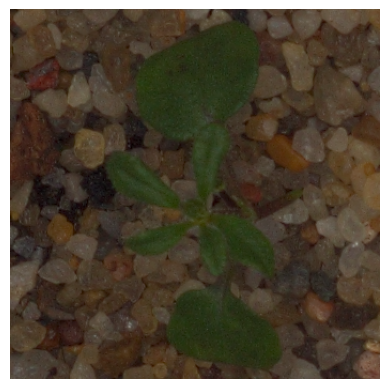

Cleavers


In [16]:
#To check the Visualize one image
plt.subplots(1)
img = Image.open(Dataset_path + 'train/Cleavers/0a1e622bc.png')
plt.imshow(img)
plt.axis('off')
plt.show()
print(seedlings[2])

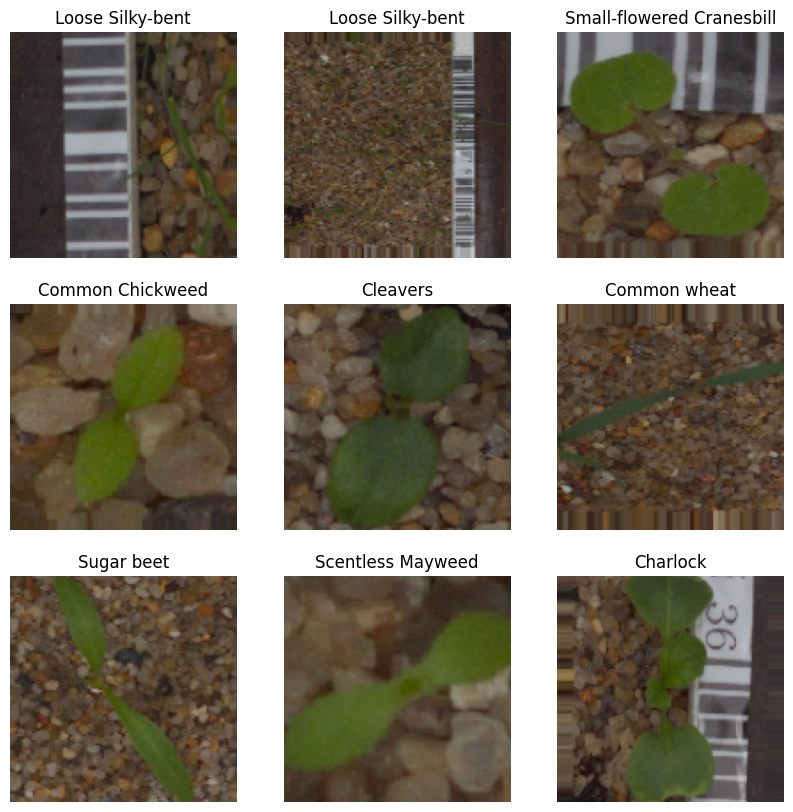

In [17]:
#Below code is to Visualize some random 9 images from the train_data batch dataset
train_generator.reset()
image_batch, label_batch = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image_batch[i])
  label = label_batch[i].astype('uint8')
  #print(label.argmax())
  plt.title(seedlings[label.argmax()])
  #print(label)
  plt.axis('off')

In [18]:
# Flatten the images for SVM
X_train_flat = X_train.reshape(X_train.shape[0], IMAGE_SIZE*IMAGE_SIZE*3)
X_train_flat.shape

(3776, 49152)

In [19]:
#below is the Function to convert y variable into categorical labeled data
def f(x):
    return seedlings[x.argmax()]

In [20]:
y_train_flat = np.array(list(map(f,y_train)))
y_train_flat[10]

'Common wheat'

In [21]:
print(y_train_flat.shape)
print(np.unique(y_train_flat))

(3776,)
['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [22]:
#Similarly for Validation Data
X_val_flat = X_val.reshape(X_val.shape[0], IMAGE_SIZE*IMAGE_SIZE*3)
y_val_flat = np.array(list(map(f,y_val)))
print(X_val_flat.shape, y_val_flat.shape)

(928, 49152) (928,)


# **Model Building**

## 1. Supervised Learning: SVM

In [23]:
#Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report
svc = SVC()
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

with tf.device('/device:GPU:0'):
  svc.fit( X_train_flat, y_train_flat)

In [24]:
with tf.device('/device:GPU:0'):
  svc_score = svc.score(X_val_flat, y_val_flat)
print(svc_score)

0.4644396551724138


In [25]:
#Prediction
y_pred_svc = svc.predict(X_val_flat)
print(classification_report(y_val_flat, y_pred_svc))

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        52
                 Charlock       0.53      0.55      0.54        78
                 Cleavers       0.61      0.49      0.54        57
         Common Chickweed       0.46      0.68      0.55       122
             Common wheat       0.00      0.00      0.00        44
                  Fat Hen       0.39      0.23      0.29        95
         Loose Silky-bent       0.39      0.94      0.55       130
                    Maize       1.00      0.16      0.27        44
        Scentless Mayweed       0.53      0.45      0.49       103
          Shepherds Purse       0.00      0.00      0.00        46
Small-flowered Cranesbill       0.60      0.60      0.60        99
               Sugar beet       0.40      0.36      0.38        58

                 accuracy                           0.46       928
                macro avg       0.41      0.37      0.35    

## 2. Deep Learning

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
model = Sequential()
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, input_shape=X_train[0].shape, activation='relu'))
model.add(Dropout(0.4))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

#model.add(Flatten())
model.add(Dense(12, activation='softmax'))

In [28]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(3776, 128, 128, 3) (3776, 12) (928, 128, 128, 3) (928, 12)


In [29]:
# Add Callbacks to pick the best model parameters
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath ='/tmp/checkpoint', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

adam_opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [30]:
with tf.device('/device:GPU:0'):
  model.fit_generator(train_generator, validation_data=validation_generator, steps_per_epoch=int(len(X_train)/32), epochs=50, callbacks=[earlystop, checkpoint])

Epoch 1/50
118/118 [==============================] - ETA: 0s - loss: 2.4346 - accuracy: 0.1750 - precision: 0.2239 - recall: 0.0159
Epoch 1: val_loss improved from inf to 2.33124, saving model to /tmp/checkpoint
118/118 [==============================] - 92s 712ms/step - loss: 2.4346 - accuracy: 0.1750 - precision: 0.2239 - recall: 0.0159 - val_loss: 2.3312 - val_accuracy: 0.1457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
118/118 [==============================] - ETA: 0s - loss: 2.0644 - accuracy: 0.2644 - precision: 0.4090 - recall: 0.0363
Epoch 2: val_loss improved from 2.33124 to 2.12649, saving model to /tmp/checkpoint
118/118 [==============================] - 84s 711ms/step - loss: 2.0644 - accuracy: 0.2644 - precision: 0.4090 - recall: 0.0363 - val_loss: 2.1265 - val_accuracy: 0.1954 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
118/118 [==============================] - ETA: 0s - loss: 1.9145 - accuracy: 0.3214 - precision: 0.5174 - reca

In [31]:
model.evaluate(validation_generator)

30/30 [==============================] - 13s 421ms/step - loss: 1.3159 - accuracy: 0.5396 - precision: 0.7204 - recall: 0.3400


[1.3158550262451172,
 0.5395987033843994,
 0.7203579545021057,
 0.34002113342285156]

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 batch_normalization (Batch  (None, 49152)             196608    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)                8

## 3. Convolution Neural Networks (CNN)

In [33]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [34]:
conv = Sequential()
conv.add(Conv2D(16, (3,3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
conv.add(BatchNormalization())
conv.add(Conv2D(32, (3,3), padding='same', activation='relu'))
conv.add(BatchNormalization())
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Dropout(0.3))

conv.add(Conv2D(32, (3,3), padding='same', activation='relu'))
conv.add(BatchNormalization())
conv.add(Conv2D(32, (3,3), padding='same', activation='relu'))
conv.add(BatchNormalization())
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Dropout(0.3))

# conv.add(Conv2D(32, (3,3), padding='same', activation='relu'))
# conv.add(BatchNormalization())
# conv.add(MaxPooling2D(pool_size=(2,2)))
# conv.add(Dropout(0.3))

# conv.add(Conv2D(64, (3,3), padding='same', activation='relu'))
# conv.add(BatchNormalization())
# conv.add(Dropout(0.2))

conv.add(Flatten())
conv.add(Dense(12))
conv.add(Activation('softmax'))

In [35]:
# Add Callbacks to pick the best model parameters
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath ='/tmp/checkpoint', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
conv.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
#conv.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [36]:
with tf.device('/device:GPU:0'):
  conv.fit( train_generator,
           validation_data=validation_generator,
           steps_per_epoch = len(X_train)/32, epochs=50, callbacks=[earlystop, checkpoint])

Epoch 1/50
118/118 [==============================] - ETA: 0s - loss: 5.5626 - accuracy: 0.3795 - precision_1: 0.3919 - recall_1: 0.3665
Epoch 1: val_loss improved from inf to 12.12604, saving model to /tmp/checkpoint
118/118 [==============================] - 91s 722ms/step - loss: 5.5626 - accuracy: 0.3795 - precision_1: 0.3919 - recall_1: 0.3665 - val_loss: 12.1260 - val_accuracy: 0.0465 - val_precision_1: 0.0465 - val_recall_1: 0.0465
Epoch 2/50
118/118 [==============================] - ETA: 0s - loss: 3.3185 - accuracy: 0.5548 - precision_1: 0.5679 - recall_1: 0.5497
Epoch 2: val_loss did not improve from 12.12604
118/118 [==============================] - 83s 706ms/step - loss: 3.3185 - accuracy: 0.5548 - precision_1: 0.5679 - recall_1: 0.5497 - val_loss: 18.8258 - val_accuracy: 0.1331 - val_precision_1: 0.1331 - val_recall_1: 0.1331
Epoch 3/50
118/118 [==============================] - ETA: 0s - loss: 2.5534 - accuracy: 0.6603 - precision_1: 0.6672 - recall_1: 0.6508
Epoch 3: v

In [37]:
conv.evaluate(validation_generator)

30/30 [==============================] - 14s 423ms/step - loss: 1.1137 - accuracy: 0.8247 - precision_1: 0.8324 - recall_1: 0.8131


[1.1137388944625854,
 0.8247095942497253,
 0.8324324488639832,
 0.8130939602851868]

In [38]:
conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_2 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_3 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                      

In [39]:
# CNN is the best performing model
conv.evaluate(X_val, y_val)

29/29 [==============================] - 0s 10ms/step - loss: 1.1327 - accuracy: 0.8233 - precision_1: 0.8311 - recall_1: 0.8114


[1.1326676607131958,
 0.8232758641242981,
 0.8311258554458618,
 0.8114224076271057]

In [40]:
best_plant_model = conv

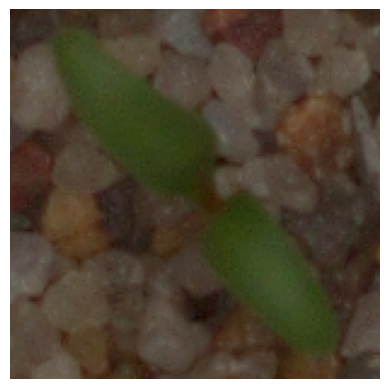

(1, 128, 128, 3)
1/1 [==============================] - 0s 51ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Predicted Class of the Plant:  Fat Hen


In [43]:
#Selecting a random image and printing actual label and predicted label for the same.

predict_imgpath = '/content/gdrive/MyDrive/Education/GL_Data/Prediction/Predict.png'
plt.subplots(1)
img = Image.open(predict_imgpath)
plt.axis('off')
plt.imshow(img)
plt.show()

pred_img = cv2.imread(predict_imgpath)
#print(pred_img.shape)
#print(pred_img[0])
pred_img = cv2.resize(pred_img, (IMAGE_SIZE, IMAGE_SIZE))
#pred_img = pred_img*1.0/255.0
img = np.expand_dims(pred_img, axis=0)
print(img.shape)
pred_plant = best_plant_model.predict(img)
print(pred_plant)
print("Predicted Class of the Plant: ", seedlings[pred_plant.argmax()])

In [ ]:
# Comparing the results from the 3 algorithms -

# - MODEL              Accuracy           Precision         Recall
# 1. SVM               46.00%               43.00%          46.00%
# ---
# 2. DNN               53.96%               72.04%          34.00%
# ---
# 3. CNN               82.47%               83.24%          81.31%
# ---



#Observations:

Training and scoring with Support Vector Machines (SVM) are time-consuming processes.

The image dataset contains a vast number of features, which is unfavorable for SVM, especially when the number of examples is relatively small.

Similarly, Deep Neural Networks (DNN) face a similar challenge, as images are often treated as flattened arrays for Dense layers in the neural network.

The limited number of training images (combining both training and validation sets) totaling around 4750 contributes to the issue of overfitting in the models.

To address the overfitting problem, three steps have been considered:

a) Utilizing the Keras ImageDataGenerator API for augmenting the training dataset.

b) Implementing batch normalization techniques.

c) Incorporating dropout mechanisms into the model.

These steps aim to enhance the model's generalization performance and mitigate the overfitting issues caused by the limited dataset size.

Thus, CNN perform the best